# Assignment 6: Tree-Based Methods

## Introduction
In this coursework, you will classify houses into **high price** and **low price** categories based on their characteristics using tree-based methods.

### **Objectives**
- Use the **Ames Housing dataset**, which contains detailed property attributes.
- Train and compare **Decision Tree, Random Forest, and XGBoost** classifiers.
- Evaluate models using **confusion matrices and ROC-AUC**.
- Optimize hyperparameters with **GridSearchCV**.
- Interpret model decisions using **SHAP explainability**.

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# SHAP for explainability
import shap
shap.initjs()

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **Dataset Description**
The dataset used is the **Ames Housing dataset**, which contains detailed information about residential houses in Ames, Iowa. Each row represents a house, and each column describes a characteristic of that house. Let's understand the **15 most important features** in the dataset:

1. **OverallQual**: The overall material and finish quality of the house.
2. **GrLivArea**: Above ground living area in square feet.
3. **GarageCars**: Number of car spaces in the garage.
4. **TotalBsmtSF**: Total basement area in square feet.
5. **1stFlrSF**: First-floor area in square feet.
6. **FullBath**: Number of full bathrooms.
7. **TotRmsAbvGrd**: Total number of rooms above ground level (excluding bathrooms).
8. **YearBuilt**: Year the house was constructed.
9. **Fireplaces**: Number of fireplaces in the house.
10. **GarageArea**: Size of the garage in square feet.
11. **LotArea**: Total lot size in square feet.
12. **KitchenQual**: Kitchen quality rating.
13. **BsmtFinSF1**: Finished basement square footage.
14. **Neighborhood**: The general location of the property within Ames.
15. **MSSubClass**: Identifies the type of dwelling.


- **Target Variable:** `SalePrice` (converted into a classification task: High vs. Low price).

## **Question 1: Data Preprocessing**
Before training your models, you need to clean and preprocess the dataset.

1. **Load the data `housing.csv` and display the first 5 rows.**

In [ ]:
# Load Ames Housing Dataset
df = pl.read_csv('housing.csv')

# Display the first few rows
df.head()

Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
i64,i64,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
0,1,526301100,20,"""RL""",31770,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,5,1960,1960,"""Hip""","""CompShg""","""BrkFace""","""Plywood""","""TA""","""TA""","""CBlock""","""GasA""","""Fa""","""Y""",1656,0,0,1656,1,0,3,1,"""TA""",7,"""Typ""",2,"""P""",210,62,0,0,0,0,0,5,2010,"""WD ""","""Normal""",215000
1,2,526350040,20,"""RH""",11622,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",896,0,0,896,1,0,2,1,"""TA""",5,"""Typ""",0,"""Y""",140,0,0,0,120,0,0,6,2010,"""WD ""","""Normal""",105000
2,3,526351010,20,"""RL""",14267,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",1329,0,0,1329,1,1,3,1,"""Gd""",6,"""Typ""",0,"""Y""",393,36,0,0,0,0,12500,6,2010,"""WD ""","""Normal""",172000
3,4,526353030,20,"""RL""",11160,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",7,5,1968,1968,"""Hip""","""CompShg""","""BrkFace""","""BrkFace""","""Gd""","""TA""","""CBlock""","""GasA""","""Ex""","""Y""",2110,0,0,2110,2,1,3,1,"""Ex""",8,"""Typ""",2,"""Y""",0,0,0,0,0,0,0,4,2010,"""WD ""","""Normal""",244000
4,5,527105010,60,"""RL""",13830,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""PConc""","""GasA""","""Gd""","""Y""",928,701,0,1629,2,1,3,1,"""TA""",6,"""Typ""",1,"""Y""",212,34,0,0,0,0,0,3,2010,"""WD ""","""Normal""",189900


1. **Convert the `SalePrice` column into a binary classification variable:**
   - If the house price is **above the median**, label it as **1 (High price)**.
   - If the house price is **below the median**, label it as **0 (Low price)**.
   
2. **Drop the original `SalePrice` column** after conversion.

3. **Encode categorical variables**:
   - Some columns contain text (e.g., `Neighborhood`, `House Style`).
   - Convert them into numerical values using **Label Encoding**.

4. **Standardize numerical features**:
   - Scale numerical values to improve model performance.
   - Use `StandardScaler()` from `sklearn.preprocessing`.

5. **Split the dataset into training and testing sets**:
   - Use an **80-20 split** (`train_test_split`).
   - Set `random_state=42` for reproducibility.
   - Use `stratify=y` to maintain class balance.

In [ ]:
# Convert SalePrice into a binary target variable (1 for high price, 0 for low price)
df = df.with_columns(
    (df["SalePrice"] > df["SalePrice"].median()).cast(pl.Int8()).alias("price_category")
)

# Drop original SalePrice column
df = df.drop("SalePrice")

# Encode categorical variables
le = LabelEncoder()
categorical_cols = [col for col in df.columns if df[col].dtype == pl.Utf8]

df = df.with_columns([
    pl.Series(col, le.fit_transform(df[col].to_list())).alias(col) for col in categorical_cols
])

# Define Features (X) and Target (y)
X = df.drop("price_category")
y = df["price_category"].to_numpy().flatten()

# Convert X to NumPy before train-test split
X_np = X.to_numpy()

# Perform Train-Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y, test_size = 0.2, random_state = 42, stratify = y)

# Standardize Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pl.DataFrame(X_train, schema=X.columns)
X_test = pl.DataFrame(X_test, schema=X.columns)
y_train = pl.Series("price_category", y_train)
y_test = pl.Series("price_category", y_test)

## **Question 2: Model Training and Evaluation**
You will train two classification models:
- **Decision Tree** (`random_state = 42`)
- **Random Forest** (`random_state = 42`)

1. **Train the models on the training set. Make sure you use the optimal number of trees for the Random Forest.**.
2. **Evaluate models using the following metrics**:
   - **Confusion Matrix**: Displays True Positives, True Negatives, False Positives, and False Negatives.
   - **ROC-AUC Score**: Measures the model’s ability to distinguish between classes.
   - **ROC Curve**: Plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

3. **Plot the ROC curves for all models in one figure**.

🔍 Processing Decision Tree...
Confusion Matrix:
[[249  44]
 [ 31 262]]
ROC AUC Score: 0.8720

🔍 Processing Random Forest...
🔍 Optimizing Random Forest with Grid Search...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
✅ Best Hyperparameters for Random Forest: {'n_estimators': 200}
Confusion Matrix:
[[273  20]
 [ 27 266]]
ROC AUC Score: 0.9788



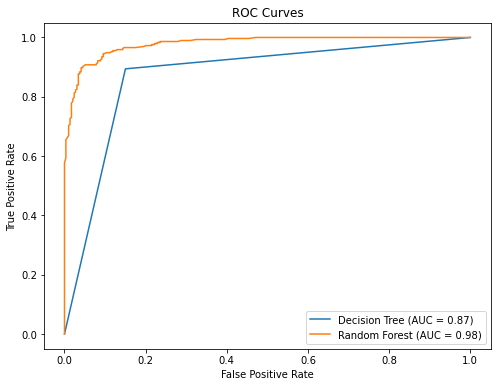

In [ ]:
# Define hyperparameter grids (only for Random Forest)
param_grids = {
    "Random Forest": {"n_estimators": [50, 100, 200]}
}

# Define base models
base_models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 42),
    "Random Forest": RandomForestClassifier(random_state = 42)
}

# Store optimized models
optimized_models = {}

# Hyperparameter tuning and model evaluation
plt.figure(figsize = (8, 6))

for name, model in base_models.items():
    print(f"🔍 Processing {name}...")

    # Apply Grid Search only for Random Forest
    if name == "Random Forest":
        print(f"🔍 Optimizing {name} with Grid Search...")
        grid_search = GridSearchCV(model, param_grids[name], cv = 5, scoring = "roc_auc", n_jobs = -1, verbose = 1)
        grid_search.fit(X_train.to_numpy(), y_train.to_numpy())
        best_model = grid_search.best_estimator_
        print(f"✅ Best Hyperparameters for {name}: {grid_search.best_params_}")
    else:
        best_model = model

    # Store the optimized model
    optimized_models[name] = best_model

    # Train the model
    best_model.fit(X_train.to_numpy(), y_train.to_numpy())

    # Predictions
    y_pred = best_model.predict(X_test.to_numpy())
    y_prob = best_model.predict_proba(X_test.to_numpy())[:, 1]

    # Evaluation metrics
    cm = confusion_matrix(y_test.to_numpy(), y_pred)
    roc_auc = roc_auc_score(y_test.to_numpy(), y_prob)

    print("Confusion Matrix:")
    print(cm)
    print(f"ROC AUC Score: {roc_auc:.4f}\n")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.to_numpy(), y_prob)
    plt.plot(fpr, tpr, label = f"{name} (AUC = {roc_auc:.2f})")

# Plot ROC Curves
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()

## **Question 3: Hyperparameter Tuning**
Hyperparameter tuning helps improve model performance by finding the best parameters.

1. **Tune XGBoost using GridSearchCV with five folds**:
   - Search for the best `n_estimators`, `max_depth`, and `learning_rate`.

2. **Show the best number for each hyperparameter**:

3. **Calculate a ROC curve and its corresponding AUC. Compare these results with the previous models.**

Fitting 5 folds for each of 27 candidates, totalling 135 fits
🔍 Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
✅ ROC AUC Score for XGBoost: 0.9797


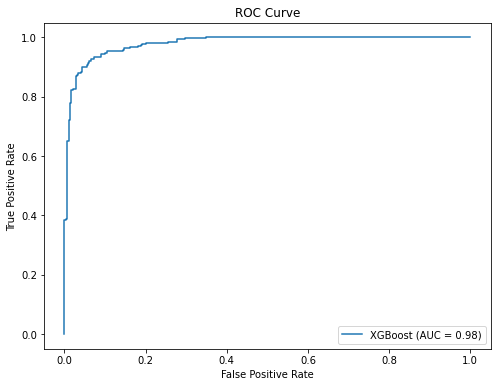

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {"n_estimators":[100, 150, 200], "max_depth":[2, 3, 5], "learning_rate":[0.01, 0.05, 0.1]}

# Initialize the XGBoost classifier
xgb = XGBClassifier(use_label_encoder = False, eval_metric = "logloss", random_state = 42)

# Perform Grid Search with 5-fold cross-validation
grid_xgb = GridSearchCV(xgb, param_grid_xgb, scoring = "roc_auc", cv = 5, n_jobs = -1, verbose = 1)
grid_xgb.fit(X_train.to_numpy(), y_train.to_numpy())

# Display the best hyperparameters
print("🔍 Best parameters for XGBoost:", grid_xgb.best_params_)

# Get the best model
best_xgb = grid_xgb.best_estimator_

# Train with best hyperparameters
best_xgb.fit(X_train.to_numpy(), y_train.to_numpy())

# Predictions
y_pred_xgb = best_xgb.predict(X_test.to_numpy())
y_prob_xgb = best_xgb.predict_proba(X_test.to_numpy())[:, 1]

# Evaluation metrics for XGBoost
roc_auc_xgb = roc_auc_score(y_test.to_numpy(), y_prob_xgb)
print(f"✅ ROC AUC Score for XGBoost: {roc_auc_xgb:.4f}")

# Plot ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test.to_numpy(), y_prob_xgb)
plt.figure(figsize = (8, 6))
plt.plot(fpr_xgb, tpr_xgb, label = f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

**Written Answer:**

It can be seen that XGBoost and Random Forest perform similarly, while Decision Tree lags behind in terms of discriminatory power.

## **Question 4: Model Explainability with SHAP**
Machine learning models can be difficult to interpret. SHAP helps us understand which features are most important in predictions.

1. **Apply SHAP to the best-tuned XGBoost model**.
2. **Generate a SHAP Summary Plot**:
   - Displays the most important features and their impact.
3. **Interpret the results**:
   - Explain the plot for the top three features?
   - Does the result make sense?

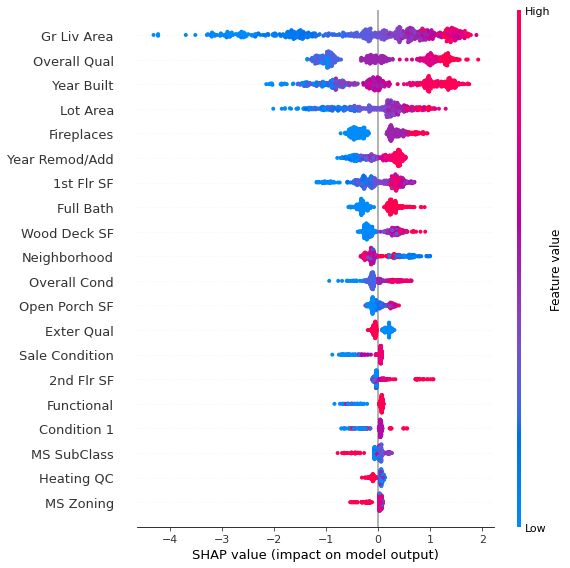

In [ ]:
# Use the best-tuned XGBoost model from GridSearch
best_xgb = grid_xgb.best_estimator_

# Apply SHAP to the best XGBoost model
X_test_pd = pd.DataFrame(X_test.to_numpy(), columns = X.columns)
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_pd)

# Generate SHAP Summary Plot
plt.figure(figsize = (10, 6))
shap.summary_plot(shap_values, X_test_pd)

**Written Answer:**

"Gr Liv Area": Larger living areas increase house prices, while smaller ones decrease them—this makes sense as size is a key value factor.

"Overall Qual": Higher-quality materials and finishes raise prices which is expected in real estate.

"Year Built": Newer houses are more valuable as they require less maintenance and are more desirable.